## 1. Install Libs

In [3]:
#-- Action we can take to the environment and current state of that environment (Discrete, Box)
#-- Discrete : Discrete Space (Action Number)
#-- Box : Box Space (set 1-100 points)
import random
import numpy as np
import matplotlib.pyplot as plt
from gym import Env
from gym.spaces import Discrete, Box 
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten

## 2. Create Own Custom RL Environment

In [12]:
#-- Environment Class for Air Con Temp, try to optimal temp as long as possible
class ACT(Env):
    def __init__(self, temp_input = 20, temp_range = 1):
        self.target_temp = temp_input
        self.temp_range = temp_range
        #-- Set action type : decrease, stay, increase
        self.action_space = Discrete(3)
        #-- Temperature Range (1 - 100)
        self.observation_space = Box(low=np.array([0]), high=np.array([100]))
        #-- Set initial temperature
        self.state = self.target_temp + random.randint(-5,5)
        #-- Set Air Con Time Stop 
        self.act_length = 120
    
    def step(self, action):
        #-- Action Type
        # 0 -1 = -1 decrease temperature
        # 1 -1 = 0 
        # 2 -1 = 1 increase temperature 
        self.state += action -1 
        #-- Reduce Air Con Time Stop by 1 second
        self.act_length -= 1 
        
        #-- Reward calculation
        if self.state >= self.target_temp - self.temp_range and self.state <= self.target_temp + self.temp_range: 
            reward =1 
        else: 
            reward = -1 
        
        #-- Check if Air Con Time Stop is 0 : done
        if self.act_length <= 0: 
            done = True
        else:
            done = False
        
        #-- 
        info = {}
        return self.state, reward, done, info

    def render(self):
        pass
    
    def reset(self, temp_input=None):
        #-- Reset Air Con temperature
        #-- Reset target temperature if provided
        if temp_input is not None:
            self.target_temp = temp_input
        #-- Reset the temperature and Air Con Time Stop
        self.state = self.target_temp + random.randint(-5, 5)
        self.act_length = 120
        return self.state
    

In [13]:
#-- Test Custom Environment Action and Observation (State)
env = ACT(temp_input = 38)
print("initital_temp_input : " ,env.target_temp)
env.reset(temp_input = 40)
print("reset_temp_input : " ,env.target_temp)
#-- From Discrete which we create : Value will between 0 to 2 which are 0, 1, 2
print("Action :",env.action_space.sample())
#-- From Box which we create : Value will between 1 to 100 
print("State :", env.observation_space.sample())

initital_temp_input :  38
reset_temp_input :  40
Action : 1
State : [60.499737]


# 3. Build Deep Learning Model

In [14]:
#-- state is the number of input data shape
#-- actions = number of output data type
#-- Deep Learning Model
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(128, activation='relu', input_shape=states))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

#-- Build Deep Learning Model
states = env.observation_space.shape
actions = env.action_space.n
model = build_model(states, actions)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               256       
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17,155
Trainable params: 17,155
Non-trainable params: 0
_________________________________________________________________


# 4. Build RL Agent Model 

In [15]:
#-- Keras Rl model 
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=100000, window_length=1)
    #-- weight update every 0.1% change
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-3)
    return dqn

In [16]:
#-- Callback Function : Reward Store 
class RewardLogger(Callback):
    def __init__(self):
        self.episode_rewards = []
        self.total_rewards = 0

    def on_episode_begin(self, episode, logs={}):
        self.total_rewards = 0

    def on_step_end(self, step, logs={}):
        self.total_rewards += logs['reward']

    def on_episode_end(self, episode, logs={}):
        self.episode_rewards.append(self.total_rewards)
    
    def plot_rewards(self):
        plt.plot(self.episode_rewards)
        plt.title("Total Reward per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.show()

Training for 40000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 6:03 - reward: -1.0000

c:\Users\HP\anaconda3\envs\rl_medium\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\HP\anaconda3\envs\rl_medium\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\HP\anaconda3\envs\rl_medium\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 33s 3ms/step - reward: -0.6378
83 episodes - episode_reward: -76.916 [-120.000, 22.000] - loss: 0.203 - mae: 1.506 - mean_q: 0.850

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 35s 4ms/step - reward: 0.7742
83 episodes - episode_reward: 92.410 [-64.000, 120.000] - loss: 0.278 - mae: 3.349 - mean_q: 2.709

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 36s 4ms/step - reward: 0.8894
84 episodes - episode_reward: 106.810 [90.000, 120.000] - loss: 1.286 - mae: 10.312 - mean_q: 14.855

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 38s 4ms/step - reward: 0.8474
done, took 141.986 seconds


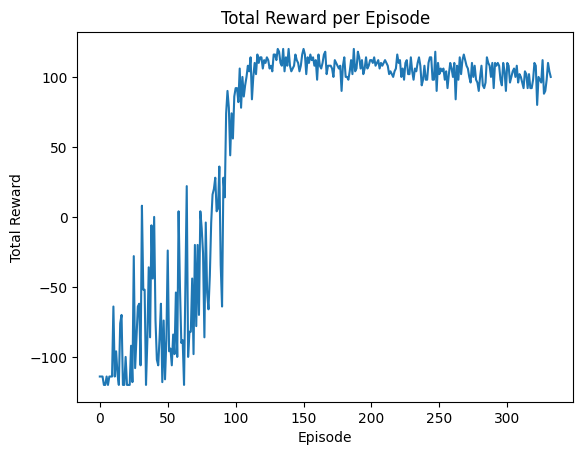

Training for 40000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 34s 3ms/step - reward: -0.8464
83 episodes - episode_reward: -101.494 [-120.000, 10.000] - loss: 0.794 - mae: 3.150 - mean_q: 6.393

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 38s 4ms/step - reward: -0.4892
83 episodes - episode_reward: -59.277 [-120.000, 52.000] - loss: 0.222 - mae: 2.178 - mean_q: -2.464

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 38s 4ms/step - reward: 0.5938
84 episodes - episode_reward: 70.548 [-44.000, 118.000] - loss: 0.295 - mae: 4.296 - mean_q: -4.265

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 37s 4ms/step - reward: 0.9180
done, took 147.085 seconds


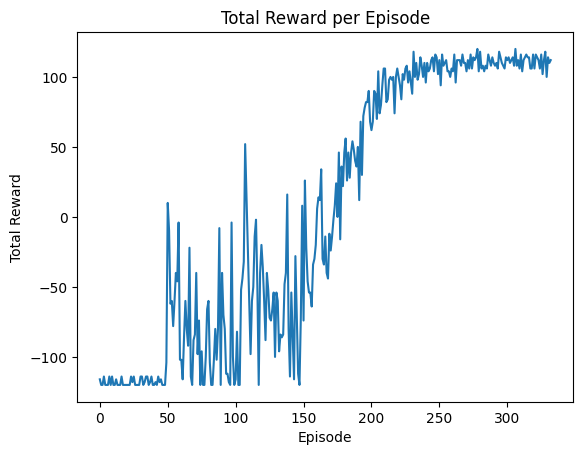

In [17]:
#- RL Model Training
for length in range(2):
    #-- Delete model cache
    del model 

    #-- build deep learning model
    model = build_model(states, actions)
    reward_logger = RewardLogger()

    #-- Set your target temperature for training, like temp_input_val = [40, 50]
    temp_input_val = [40,50]
    env = ACT(temp_input = temp_input_val[length])

    #-- build dqn model
    dqn = build_agent(model, actions)
    dqn.compile(Adam(lr=1e-3), metrics=['mae'])
    dqn.fit(env, nb_steps=40000, visualize=False, verbose=1, callbacks=[reward_logger])
    dqn.save_weights('dqn_temp_' + str(temp_input_val[length]) + '_weights.h5f', overwrite=True)
    #-- Plot toal reward
    reward_logger.plot_rewards()

## 5. Running the Agent Environment

In [18]:
#-- Running the Agent Environment (Temp Control Should be 40 and 50)
#-- delete model cache
del model 
#-- build deep and dqn model
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

#-- Set input temperature control
temp_control = int(input("Enter Your Air Condition Temperature: "))
print(f"Your Air Con Temperature Target is {temp_control} .")
if(temp_control == 40 or temp_control == 50):
    dqn.load_weights('dqn_temp_' + str(temp_control) + '_weights.h5f')
    env = ACT(temp_input = temp_control)
    scores = dqn.test(env, nb_episodes=10, visualize=False)
    print('Mean Reward Value is : ',np.mean(scores.history['episode_reward']))
else: print("Please Adjust your Air Conditioner Temperature Control to be 40 or 50")

c:\Users\HP\anaconda3\envs\rl_medium\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Your Air Con Temperature Target is 40 .
Testing for 10 episodes ...
Episode 1: reward: 116.000, steps: 120
Episode 2: reward: 116.000, steps: 120


c:\Users\HP\anaconda3\envs\rl_medium\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\HP\anaconda3\envs\rl_medium\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 3: reward: 120.000, steps: 120
Episode 4: reward: 120.000, steps: 120
Episode 5: reward: 116.000, steps: 120
Episode 6: reward: 120.000, steps: 120
Episode 7: reward: 120.000, steps: 120
Episode 8: reward: 120.000, steps: 120
Episode 9: reward: 116.000, steps: 120
Episode 10: reward: 120.000, steps: 120
Mean Reward Value is :  118.4
